In [1]:
import numpy as np

In [9]:
i= np.random.randint(0, high=255, size=(4, 4, 3), dtype='uint8')

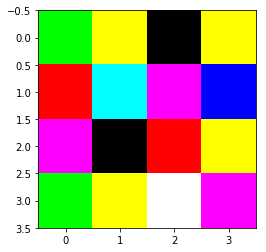

In [12]:
def f(i):
    if i>(256/2): return 255
    else: return 0
    
f=np.vectorize(f)

image=f(i)
plt.imshow(image)
plt.show()

In [1]:
import math
import matplotlib

In [ ]:
import scipy
from PIL import Image

In [691]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math


def conv2D(image, filt, padding='reflect', **kwargs): #1 Channel Conv2D
        pad=int((filt.shape[0]-1)/2)
        m,n=filt.shape
        i,j=image.shape
        weight=1/filt.sum()
        if padding is None:
            padded=image #don't pad. used for sharpenning where  padding messes things up
            c=np.asarray([[(weight*np.multiply(padded[x:x+m,y:y+n],filt)).sum()
                      for y in range(j-n+1)] for x in range(i-m+1)])
            return c.reshape((i-m+1, j-n+1))
        else:
            padded=np.pad(image, pad_width=pad, mode=padding, **kwargs) 
            c=np.asarray([[(weight*np.multiply(padded[x:x+m,y:y+n],filt)).sum()
                      for y in range(j)] for x in range(i)])
            return c.reshape(image.shape)

In [692]:
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
class iImage(object):
    def __init__(self, image):
        """Custom Image Class with inbuilt Transforms
        Parameters
        ------------
        image: Numpy nD array for RGB Color Image, or Grayscale Image
        
        Returns
        ------------
        iImage Object
        """
        if image.shape[2]==3:                         # 3 Channel Image
            if not self.is3CGrayScale(image):              #Is 3 Channel RGB Image
                self.isRGB=True
                self.OGImage=rgb_to_hsv(image)        
                self.ImageV=self.OGImage[:,:,2]       #Current HSV Image V Channel (Inatialised to Original)
            else:                                    #Is 3 Channel GrayScale
                self.isRGB=False
                self.OGImage=image[:,:,0]            #Use First Channel as Grayscale
                self.ImageV=image[:,:,0]       
        else:
            self.OGImage=image
            self.ImageV=self.OGImage.copy()              #Current GrayScale image
            self.isRGB=False
        
        self.history=[]          #Saves different version of the image transformed over time
        self.VChannel=self.ImageV.copy() #Used to checkout any state in History
    
    @classmethod
    def load(cls, path):
        rawImage=Image.open("/home/sufiyan/Downloads/eye.png").convert('RGB')
        rawImage=np.asarray(rawImage)
        return cls(rawImage)
    
    
    @property
    def RGB(self):  return self.getRGB().astype('uint8')   #Used to return RGB Image After Transforms
    
    @property
    def V(self): return self.ImageV
        
    def getRGB(self, VChannel=None):       #Used to return RGB from custom HSV VChannel
        if VChannel is None: VChannel=self.ImageV
        if self.isRGB:
            return hsv_to_rgb(np.dstack(
                (self.OGImage[:,:,0], self.OGImage[:,:,1], VChannel)))
        else: return np.dstack((VChannel, VChannel, VChannel))
        
        
#     def getHS(self):
#         return 
    
    def is3CGrayScale(self, image): #Checks if 3Channnel Image is Greyscale
        return not(False in ((image[:,:,0]==image[:,:,1]) == (image[:,:,1]==image[:,:,2])))
    
    def checkSave(self, transformedImage, save):
            if save: 
                self.history.append(transformedImage)
                self.ImageV=transformedImage
                return self
            else:
                return iImage(self.getRGB(VChannel=transformedImage))
    
    def lotTransform_(self, base=None): return self.logTransform(base,save=True) #Inplace (PyTorch Like)
    def logTransform(self, base=None, save=False): #Log  Transforms
        """
        Parameters
        base: base value for Log Transform. default Loge
        save: Save the Transformed Image to History
        """
        import math
        if base:  base = int(base)    #If base is provided, use it, else Natural Log e
        c=255/math.log(1+self.ImageV.max())   #Scaling Constant for Gamma Transform
        if base: func = np.vectorize(lambda x: int(c*math.log(1+x, base))) #element wise log transform
        else:    func = np.vectorize(lambda x: int(c*math.log(1+x)))
        transformedV= func(self.ImageV)
        return checkSave(transformedV, save)
    
    def show(self):
        import matplotlib.pyplot as plt
        plt.imshow(self.RGB)
        return self
    def gammaTransform_(gamma=None): self.gammaTransform(gamma, save=True) #Inplace (PyTorch Like)
    def gammaTransform(self,gamma=None, save=False):
        if gamma is None: self.gamma=1
        else: self.gamma=gamma
        from math import pow
        
        func = np.vectorize(lambda x: pow(x, self.gamma))
        transformedG=func(self.ImageV/self.ImageV.max()) #Gamma of Normalized Image
        transformedG = transformedG*(255/transformedG.max()) #Denormalizing to 8bit
        return checkSave(transformedG, save)
    
    def histEqualization_(self): return self.histEqualization(save=True) #Inplace (PyTorch Like)
    def histEqualization(self, save=False):
        import numpy as np
        pdf,bins=np.histogram(ImageV, bins=256, density=True) #Returns PDF at intensity(bin)
        cdf=pdf.cumsum() #calc cdf at each intensity bin
         #normalize histogram,scale by 255  and 8 bit
        transformedH=(np.interp(rawImage, bins[:-1], cdf)*255).astype('uint8')
        return checkSave(transformedH, save)
    
    def blur_(kernelSize=3): self.blur(kernelSize, save=True) #Inplace (PyTorch Like)
    def blur(self, kernelSize=3, save=False):
        if kernelSize<1: kernelSize=1 #Handle all possible human error in kernel size
        elif kernelSize%2!=1:
            if int(kernelSize)%2==1: kernelSize=int(kernelSize)
            else: kernelSize=int(kernelSize)-1
        transformedB=conv2D(self.ImageV, np.ones(shape=(kernelSize,kernelSize)))
        return self.checkSave(transformedB, save)
    
    def sharpen_(self, weight=0.5): self.sharpen(weight, save=True)
    def sharpen(self, weight=0.5, save=False):
        if weight<0:  weight = 0
        if weight >1: weight = weight
        blured=self.blur().V
        blured=blured/blured.max()  #Normalized to max 0-1
        orignal=self.ImageV/self.ImageV.max()
        transformedS = np.add(orignal*(1-weight), np.subtract(orignal, blured)*weight) #Unsharp Masking Wikipedia
        transformedS = np.add(self.ImageV, np.subtract(blured, orignal)*weight)
        print((np.subtract(orignal, blured)*weight).max())
        transformedS=np.clip(transformedS, 0, 255)
#         transformedS= transformedS*(255/transformedS.max())
        return self.checkSave(transformedS, save)

    def sharpen2_(self, weight=0.5): self.sharpen2(weight, save=True)
    def sharpen2(self, weight=0.5, save=False):
        if weight<0:  weight = 0
        if weight >1: weight = weight
        #kernel from https://nptel.ac.in/courses/117104069/chapter_8/8_32.html
        kernel=0.34*np.asarray([[8 if x==y else -1 for y in range(3)] for x in range(3)])
        image=self.ImageV/self.ImageV.max()
        filtered=conv2D(image, kernel, padding=None, constant_values=0)
        #Avoiding Padding makes image smaller, so adding 0 pad after extracting edges
        filtered=np.pad(filtered, pad_width=int((kernel.shape[0]-1)/2), mode='constant', constant_values=0)
        edges= np.subtract(filtered, image)
        edges=edges*255/edges.max()
        transformedS=np.add(self.ImageV, edges*weight)
        transformedS=np.clip(transformedS, 0, 255)
        return self.checkSave(transformedS, save)

In [2]:
from PIL import Image

In [3]:
import numpy as np

rawImage=Image.open("/home/sufiyan/Downloads/eye.png").convert('RGB')
# rawImage=np.asarray(rawImage)

In [4]:
rawImage.im

In [695]:
import matplotlib.pyplot as plt
image=iImage(np.asarray(rawImage))

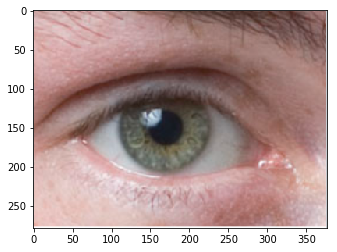

In [696]:
plt.imshow(image.RGB)

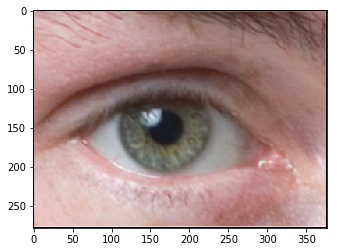

In [704]:
plt.imshow(image.sharpen2(0.2).RGB)